#  Remind A/B Test
## 테스트 과정
1. 실험설계
2. 테스트진행
3. 테스트 결과 보기
4. 의사결정

* 단점
    * 테스트 기간동안의 손실
        * A,B 중 B가 좋았을때 테스트 기간 동안 A에서 발생하는 손실
    * 의사결정
        * 하나를 선택해야함

# MAB
* Multi-Armed Bandit : 팔(=손잡이)이 여러개인 밴딧(=슬롯머신)
* 당첨확률을 알지못하는 여러개의 슬롯머신

<img src=https://miro.medium.com/max/1400/0*HzEtbuVNyje5BzqB width="400">

## MAB 문제
* 슬롯을 땡길때 이익을 최대화(=손실을 최소화)하는 전략
* 어떻게 땡겨야 이익을 최대화 할 수 있는가?
    * 직감으로 하나만 선택해서 올인
    * 번갈아가면서 땡겨보다가 첫번째로 당첨된 머신에 올인
    * 100번씩 땡겨보고 좋은 머신에 올인
    * 등 등 

## MAB 알고리즘
* MAB 문제를 풀기위한 알고리즘
* 방법들
    * Greedy
    * $\epsilon$-Greedy
    * UCB
    * $\star$ **Thomson Sampling** $\star$ 
        * 직관적
        * 구현이 간단하고 성능이 좋음 

## Thomson Sampling 방법
* 당첨확률이 안좋은 슬롯머신은 실험기회를 감소, 당첨확률이 좋은 슬롯머신은 실험기회를 증가
    * 실험 : 땡기는 행위 = 노출
* 어떻게!
    * 베이지안 접근방법
    * 슬롯을 땡기는 행위=시행, 당첨=성공은 베르누이 분포(=한번의 실험)
    * 성공수는(=여러번의 실험) 이항분포(n,p) 따르며, 이항분포의 사후분포는 베타분포($\alpha,\beta$) ([참고자료](https://github.com/birdviewdev/datateam-analytics/blob/main/Study/202112_abtest/introBayesian_yimdh.ipynb))
        * 베타분포의 평균 = $\frac {\alpha}{\alpha+\beta}$ 
        * $\alpha$=당첨,$\beta$=낙첨 이라고 했을때 베타분포의 평균은 표본의 당첨확률과 같음
        * 실험의 결과(사전정보)로 사후분포(베타분포)를 업데이트하고 이를 통해 실험기회를 조절

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/540px-Beta_distribution_pdf.svg.png width="300">

## 예제

### 설정
+ 당첨 확률이 다른 $A$,$B$,$C$ 3개의 슬롯머신
+ 초기 분포 $Beta(1,1)$

### 초기화
+ 분포 parameter ($\alpha=1$, $\beta=1$)
+ 당첨확률 trueP

### 과정
+ $step 0.$ 각각의 슬롯머신의 분포 초기화
+ $step 1.$ 각각의 분포에서 난수를 생성
+ $step 2.$ 뽑힌 난수에서 최대값을 찾음
+ $step 3.$ 최대값이 추출된 분포에 맵핑되는 후보를 실험
+ $step 4.$ 결과(실패or성공)에 따라 해당 분포의 모수 업데이트
+ $step 5.$ $step1$~$4.$ 을 충분히 반복

### 수행

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
class Bandit:
    def __init__(self,name,trueP):
        self.name=name
        self.alpha=1
        self.beta=1
        self.trueP=trueP
    def get_name(self): #이름을 반환
        return(self.name)
    def print_parameter(self): #베타분포의 모수 출력
        print("name  : ",self.name,"/ alpha : ",self.alpha, "/ beta  : ",self.beta,"\ trueP : ",self.trueP,"\n")
    def get_sample(self): #현재 베타분포에서 난수하나를 반환
        return(np.random.beta(a=self.alpha, b=self.beta, size=1)[0])
    def get_testResult(self,printYN): #실험결과 반환
        testResult=np.random.binomial(1,self.trueP,size=1)[0]
        if printYN=='Y' : print("실험 결과 : ",testResult,"\n")
        return(testResult)
    def set_parameter(self,result,printYN):#모수 업데이트
        if result==1 :
            self.alpha=self.alpha+1
            if printYN=='Y' : print(self.name,"파라미터 업데이트 alpha + 1","\n")
        else :
            self.beta=self.beta+1
            if printYN=='Y' : print(self.name,"파라미터 업데이트 beta + 1","\n")
    def plot_dist(self) : #현재 분포 그래프 출력
        mean = round(self.alpha/(self.alpha+self.beta),3)
        xx = np.linspace(0, 1, 100)
        rv = sp.stats.beta(self.alpha,self.beta)
        pdf = rv.pdf(xx)
        plt.plot(xx, pdf)
        plt.title(self.name+"'s pdf of $Beta$("+str(int(self.alpha))+","+str(int(self.beta))+"), "+"mean="+str(mean))
        plt.xlabel("$x$")
        plt.ylabel("$p(x)$") 

        
class Thomson(ban):
        
def ploting(): #A,B,C 분포 그래프 한번에 그리기
    print("currents distribution of A,B,C")
    plt.figure(figsize=(18,6))
    plt.subplot(131);bandits[0].plot_dist();
    plt.subplot(132);bandits[1].plot_dist();
    plt.subplot(133);bandits[2].plot_dist();
    plt.show()
def get_argmax(arr,printYN): #난수 중 최대값위치 반환
    samples=[arr[i].get_sample() for i in range(0,len(arr))]
    argmax=samples.index(max(samples))
    if printYN=='Y' : 
        print("각 분포에서 추출된 난수 : ",samples,"\n최대값이 나온 슬롯머신 : ",arr[argmax].get_name(),"\n")
    return(argmax)

#### $step 0.$ 각 bandit 분포 초기화

currents distribution of A,B,C


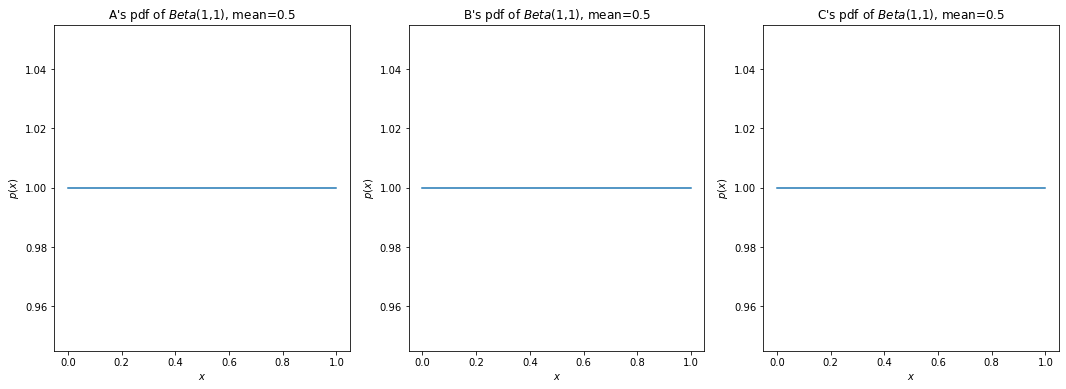

name  :  A / alpha :  1 / beta  :  1 \ trueP :  0.3 

name  :  B / alpha :  1 / beta  :  1 \ trueP :  0.33 

name  :  C / alpha :  1 / beta  :  1 \ trueP :  0.35 



In [3]:
bandits=[Bandit('A',0.3),Bandit('B',0.33),Bandit('C',0.35)]

ploting()
for i in range(0,3): bandits[i].print_parameter()

#### $step 1.$ 각각의 분포에서 난수를 생성
#### $step 2.$ 뽑힌 난수에서 최대값을 찾음

In [4]:
try_bandit=get_argmax(bandits,'Y')

각 분포에서 추출된 난수 :  [0.6146769845255544, 0.6628243995094089, 0.4523223003825376] 
최대값이 나온 슬롯머신 :  B 



#### $step 3.$ 최대값이 추출된 분포에 맵핑되는 후보를 실험

In [5]:
result_bandit=bandits[try_bandit].get_testResult('Y')

실험 결과 :  1 



#### $step 4.$ 결과(실패or성공)에 따라 해당 분포의 모수 업데이트

In [6]:
bandits[try_bandit].set_parameter(result_bandit,'Y')

B 파라미터 업데이트 alpha + 1 



name  :  A / alpha :  1 / beta  :  1 \ trueP :  0.3 

name  :  B / alpha :  2 / beta  :  1 \ trueP :  0.33 

name  :  C / alpha :  1 / beta  :  1 \ trueP :  0.35 

currents distribution of A,B,C


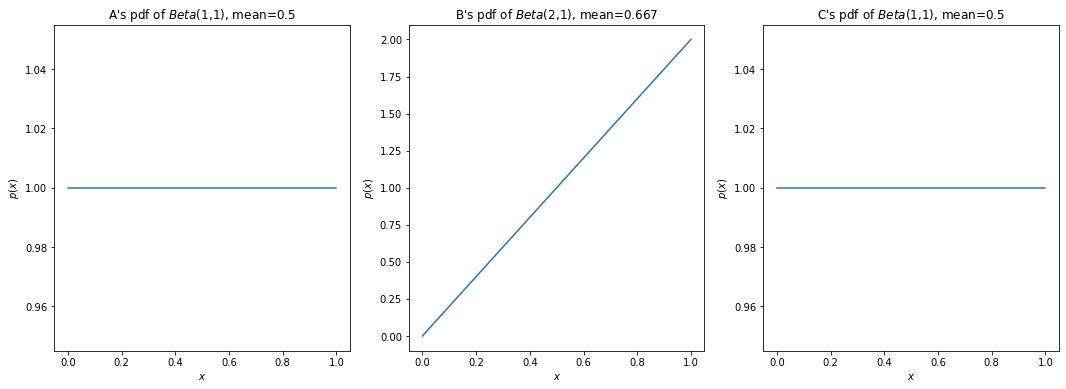

In [7]:
for i in range(0,3):bandits[i].print_parameter()
ploting()

#### $step 5.$ $step1$~$4.$ 을 수렴할때까지 충분히 반복

In [11]:
bandits=[Bandit('A',0.3),Bandit('B',0.33),Bandit('C',0.35)]
try_bandit_list=[]
for rep in range(1,10001):
    try_bandit=get_argmax(bandits,'N')
    result_bandit=bandits[try_bandit].get_testResult('N')
    bandits[try_bandit].set_parameter(result_bandit,'N')
    try_bandit_list.append(try_bandit)
    

name  :  A / alpha :  159 / beta  :  378 \ trueP :  0.3 

name  :  B / alpha :  751 / beta  :  1546 \ trueP :  0.33 

name  :  C / alpha :  2489 / beta  :  4683 \ trueP :  0.35 

currents distribution of A,B,C


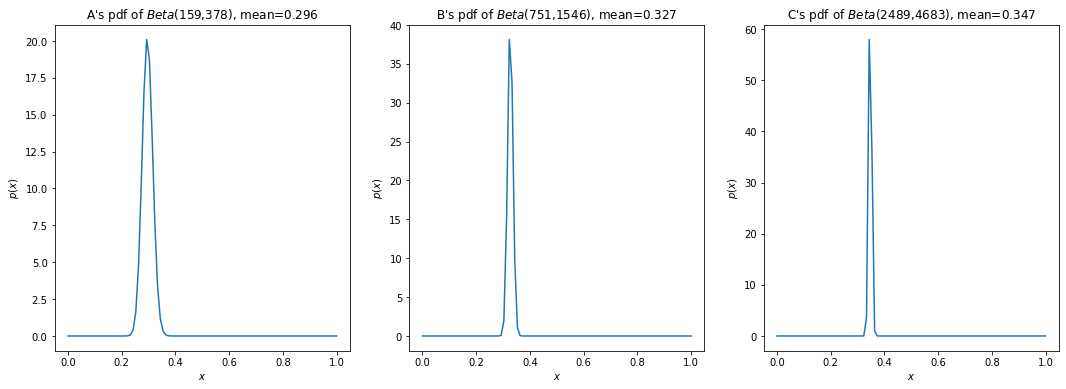

In [12]:
for i in range(0,3):bandits[i].print_parameter()
ploting()

* 처음 실험부터 100개씩 나누어 각 슬롯머신별 수행한 실험수를 집계  
ex) (1~100) 실험 A:20,B:30,C:50

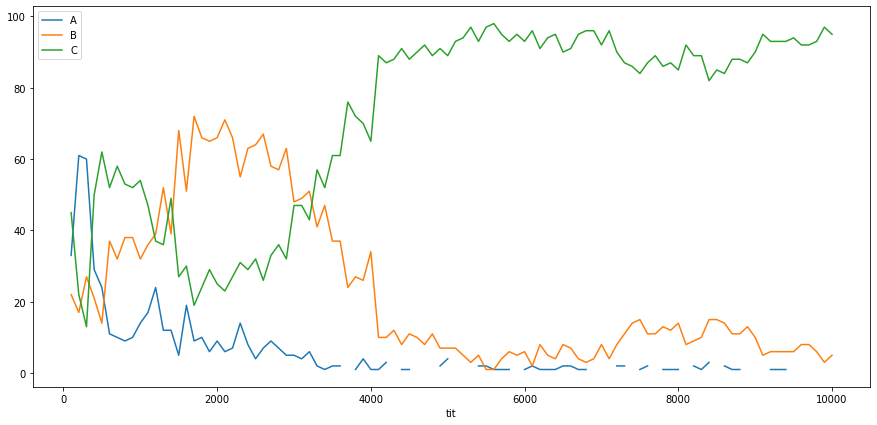

In [44]:
a=list(np.linspace(100, 10000, 100))
b=[1]*100
gen = [x*y for x in a for y in b]
tmp = try_bandit_list
data=DataFrame({'idx':tmp,'tit':gen,'n':tmp})

fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['tit','idx']).count().unstack().plot(ax=ax)
plt.legend(["A", "B","C"]) 
plt.show()
